In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [31]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [33]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
measurement = base.classes.measurement 
station = base.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set.
recentdate = session.query(measurement.date).order_by(measurement.date.desc()).first()
recentdate

('2017-08-23',)

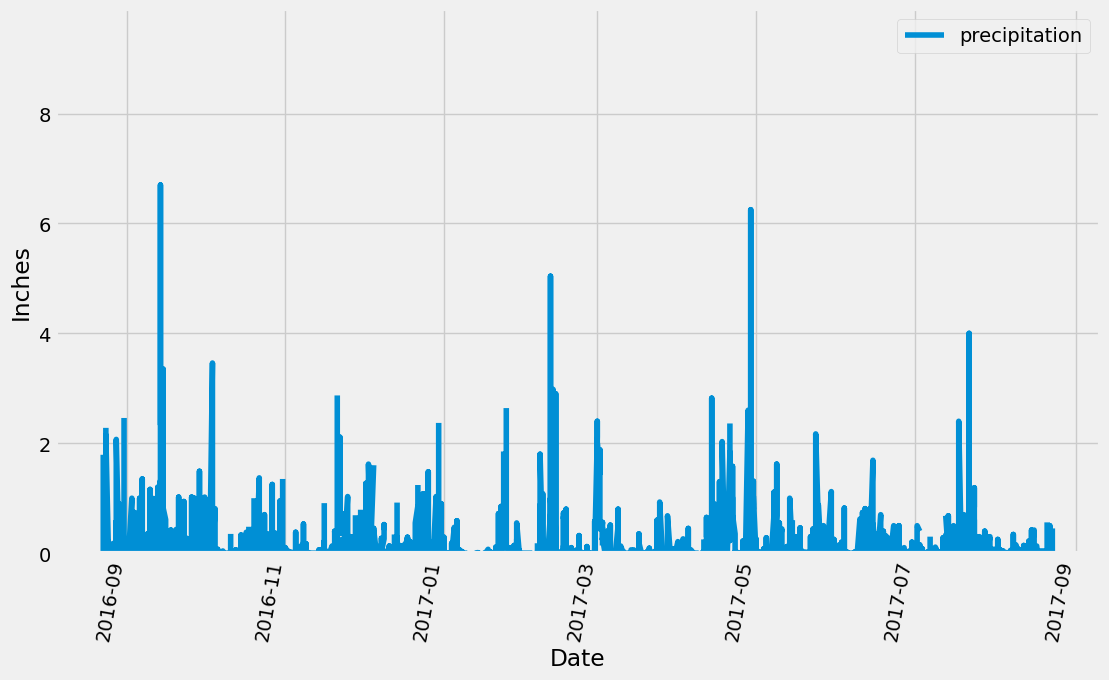

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recentdate = dt.date(2017,8,23)
# Calculate the date one year from the last date in data set.
one_year_from_last = recentdate - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_from_last).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation).rename(columns = {'prcp': 'precipitation'})

# fix date format
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
# fix index
df = df.set_index('date')
# Sort the dataframe by date
df = df.sort_values(by = ['date'])

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize = (12,8), rot=80)
plt.ylim(0,9.9)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.legend(loc = 'upper right')

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = df.describe()
stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number of stations in the dataset
session.query(station).first().__dict__
session.query(measurement).first().__dict__
num = len(session.query(station).all())
print(num)

9


In [40]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
mostactivestations = session.query(measurement.station,
                              func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
mostactivestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station, 
      func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]
most_active = session.query(*sel).filter_by(station = "USC00519281").all()

print(f"The lowest temperature for {most_active[0][0]} is {most_active[0][1]}")
print(f"The highest temperature for {most_active[0][0]} is {most_active[0][2]}")
print(f"The average temperature for {most_active[0][0]} is {most_active[0][3]}")

The lowest temperature for USC00519281 is 54.0
The highest temperature for USC00519281 is 85.0
The average temperature for USC00519281 is 71.66378066378067


Text(0, 0.5, 'Frequency')

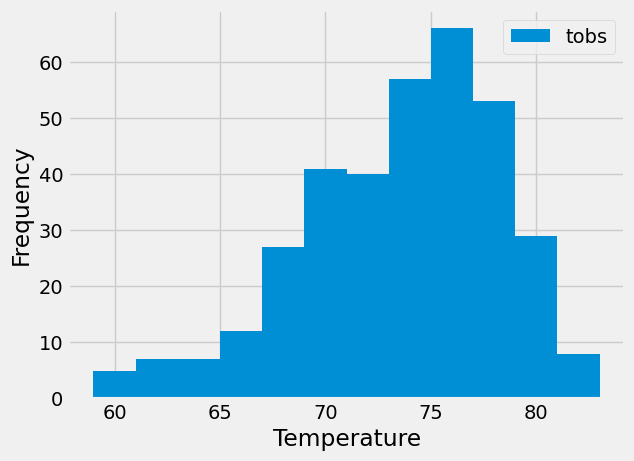

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12m = session.query(measurement.date, measurement.tobs).filter_by(station = "USC00519281").\
    filter(measurement.date >= one_year_from_last).all()
#convert to dataframe to plot data
last12mdf = pd.DataFrame(last12m)
#plot
last12mdf.plot(kind = 'hist', bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Close Session

In [43]:
# Close Session
date_prcp = session.query(measurement.date, measurement.prcp).all()
num = []
for date, prcp in date_prcp:
    date_dict = {}
    date_dict[date] = prcp
    num.append(date_dict)
session.close()